<a href="https://colab.research.google.com/github/andrewsknight/DeepLearning-Models/blob/main/Practica_Final_Deep_Learning_Andr%C3%A9sCaballero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

--2023-02-11 20:51:18--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.249.199.226, 34.248.20.69
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [   <=>              ]  54.31M  3.09MB/s    in 18s     

2023-02-11 20:51:37 (2.99 MB/s) - ‘airbnb-listings.csv’ saved [56950929]



In [ ]:
import pandas as pd
from sklearn import preprocessing
df = pd.read_csv('airbnb-listings.csv', sep = ';')
pd.options.display.max_columns = None


In [ ]:
df.head().T

,0,1,2,3,4
ID,3150371,3378181,2070750,9832499,1868170
Listing Url,https://www.airbnb.com/rooms/3150371,https://www.airbnb.com/rooms/3378181,https://www.airbnb.com/rooms/2070750,https://www.airbnb.com/rooms/9832499,https://www.airbnb.com/rooms/1868170
Scrape ID,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,Double room + bathroom - La Latina,"Ópera/Plz Mayor -- A/C, elevator",Centric room with a balcony,PLAZA DE ESPAÑA - Único - Gimnasio.,"Loft/duplex 150m2, 3 double rooms"
...,...,...,...,...,...
Cancellation Policy,flexible,strict,flexible,strict,moderate
Calculated host listings count,1,2,4,9,1
Reviews per Month,2.33,2.69,0.6,3.56,1.13
Geolocation,"40.41010608050749,-3.714754034177323","40.416968822636726,-3.7094389211089993","40.40970517560235,-3.7135611928841086","40.42319271738103,-3.7112486513892","40.416513932601625,-3.7178427529546973"


In [ ]:
#Creo una copiar que necesitaré mas adelante para cargar las imágenes.
df_img = df.copy()

In [ ]:
# vamos a ver de cuantos registros disponemos y de cuantas variables
df.shape

(14001, 89)

**Análisis exploratorio y limpieza del dataset**

In [ ]:
#Creo una lista con las columnas que a simple vista o indagando un poco , apenas influyen en el modelo

drop_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 'Medium Url',
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name',
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price',
    'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review',
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count', 'Street', 'State', 'Market', 'Smart Location',
    'Country', 'Zipcode', 'City', 'Country Code', 'Experiences Offered','Name', 'Summary', 'Space', 'Description',
    'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules','Host Location', 'Host About'
]

df.drop(drop_columns, axis=1, inplace=True)

In [ ]:

#Borramos columnas con muchos NA's

na_columns = [
    'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names'
]

df.drop(na_columns, axis=1, inplace=True)


#Al correlacionarse tanto las variables de availability y reviews, dejamos solo la de availability 365
#hacemos una media con todas las columnas de Review y las guardamos en la columna 'Average Review'.

reviews = df.loc[: , "Review Scores Rating":"Review Scores Value"]
df['Average Review'] = reviews.mean(axis=1)

df.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating',
         'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
        'Accommodates'], axis=1, inplace=True)


#Solo nos quedamos con los precios inferiores a 200 para evitar sobreajustes en el modelo
df = df[df['Price'] < 200]


**GENERACIÓN DE CARACTERÍSTICAS**

In [ ]:

#creamos un subconjunto visto que las columnas de barrios, la primera son más específicos y la segundo menos y la última menos.
#Rellenamos los valores con NA de la columna 'Neighbourhood Group Cleansed' con los de la columna 'Neighbourhood Cleansed'
#que no tiene NA's, y nos creamos una sola columna ( "Final Neighbourhood") en representación de las 3·

df["Final Neighbourhood"] = df["Neighbourhood Group Cleansed"].fillna(df["Neighbourhood Cleansed"])
df.drop(["Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"], axis=1, inplace=True)


# Rellenamos con cadenas vacías los NA de las tres columnas('Features','Amenities', 'Host Verifications' ), para codificar correctamente las categóricas.
# Contamos el numero de elementos de cada columna, y lo usamos como caraterística sustituyendo
# los elementos por su longitud. Vemos que hay buena relación entre el numero de elementos y el precio.


df['Features'].fillna("", inplace=True)
df['Amenities'].fillna("", inplace=True)
df['Host Verifications'].fillna("", inplace=True)

df['Features'] = df['Features'].apply(lambda x: len(str(x).split(',')))
df['Amenities'] = df['Amenities'].apply(lambda x: len(str(x).split(',')))
df['Host Verifications'] = df['Host Verifications'].apply(lambda x: len(str(x).split(',')))

# Antiguedad del dueño

from datetime import datetime

df.dropna(subset=['Host Since'], inplace=True) # se ha visto antes que solo hay tres valores missing, los borramos.

# En vez de la fecha nos quedamos con la antigueda que lleva el dueño en la plataforma.


#Convertimos a un formato horario manejable
df['Host Since'] = df['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))

#Restamos la fecha actual menos la del dataframe y nos quedamos con los años.
df['Years Being Host'] = df['Host Since'].apply(lambda x: 2023 - x.year)

#Borramos esta columna que ya no nos sirve
df.drop(['Host Since'], axis=1, inplace=True)

**CATEGORIZACIÓN DE VARIABLES**

In [ ]:
from sklearn.preprocessing import LabelEncoder


#Nos quedamos con aquellos elementos distintos de 0.

df = df[df['Bathrooms'] != 0]
df = df[df['Price'] != 0]
df["Host Response Time"].fillna(df["Host Response Time"].mode()[0], inplace=True)


# Codificamos las categóricas que nos quedan creando un labelEncoder para cada una, y sustituimos los valores.


Host_Response_Time_le = LabelEncoder()
Property_Type_le = LabelEncoder()
Room_Type_le = LabelEncoder()
Bed_Type_le = LabelEncoder()
Cancellation_Policy_le = LabelEncoder()
Final_Neighbourhood_le = LabelEncoder()


df['Host Response Time'] = Host_Response_Time_le.fit_transform(df['Host Response Time'] )
df['Property Type'] = Property_Type_le.fit_transform(df['Property Type'] )
df['Room Type'] = Room_Type_le.fit_transform(df['Room Type'])
df['Bed Type'] = Bed_Type_le.fit_transform(df['Bed Type'])
df['Cancellation Policy'] = Cancellation_Policy_le.fit_transform(df['Cancellation Policy'] )
df['Final Neighbourhood'] = Final_Neighbourhood_le.fit_transform(df['Final Neighbourhood'])






# Esto solo sirve para mover price a la primera posición
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df = df[cols]

#Sustituimos los Nas que queden por la media.

df.fillna(df.mean(), inplace=True)
df.isnull().any()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Price                  False
Host Response Time     False
Host Response Rate     False
Host Verifications     False
Latitude               False
Longitude              False
Property Type          False
Room Type              False
Bathrooms              False
Bedrooms               False
Beds                   False
Bed Type               False
Amenities              False
Security Deposit       False
Cleaning Fee           False
Guests Included        False
Extra People           False
Minimum Nights         False
Maximum Nights         False
Availability 365       False
Number of Reviews      False
Cancellation Policy    False
Features               False
Average Review         False
Final Neighbourhood    False
Years Being Host       False
dtype: bool

In [ ]:
df.shape

(13332, 26)

In [ ]:
#Filtro una copia del dataframe original por los entradas del dataframe limpio para añadir las URLs de las imágenes a cada entrada la suya.

df_filtered = df_img.loc[df_img.index.isin(df.index)]
df_final = pd.concat([df, df_filtered['Thumbnail Url']], axis = 1)

In [ ]:
df_final.head().T

,0,1,2,3,4
Price,36.0,85.0,20.0,112.0,190.0
Host Response Time,1,1,1,3,2
Host Response Rate,100.0,94.0,80.0,100.0,100.0
Host Verifications,4,6,4,6,4
Latitude,40.410106,40.416969,40.409705,40.423193,40.416514
Longitude,-3.714754,-3.709439,-3.713561,-3.711249,-3.717843
Property Type,0,0,0,0,0
Room Type,1,0,1,0,0
Bathrooms,1.0,1.0,1.0,1.0,3.0
Bedrooms,1.0,1.0,1.0,1.0,3.0


In [ ]:

import imageio as io
import numpy as np
import cv2
n_images = 1500
images = np.zeros((n_images, 224, 224, 3), dtype=np.uint8)
urls = df_final['Thumbnail Url']

i_aux = 0
good_urls = []
images_train = []
for i_img, url in enumerate(urls):
    if len(good_urls) >= n_images:
        # ya tenemos n_images imágenes
        break
    try:
        img = io.imread(url)
        images_aux = cv2.resize(img, (224, 224))
        if images_aux.shape == (224, 224, 3):
            images[i_aux] = images_aux
            good_urls.append(i_img)
            i_aux += 1
            print(f'Imagen {i_img} descargada')
            print(len(good_urls))
        else:
          pass
    except IOError as err:
        pass

In [ ]:
# Visualizamos las imágenes cargadas
print(images.shape)

(1500, 224, 224, 3)


In [ ]:
# Mantenemos los datos numéricos solo para aquellos pisos que tienen imágenes
# y las hemos obtenido
final_data = df_final.iloc[good_urls, :]

In [ ]:
print(final_data.shape)

(1500, 27)


In [ ]:
final_data.columns

Index(['Price', 'Host Response Time', 'Host Response Rate',
       'Host Verifications', 'Latitude', 'Longitude', 'Property Type',
       'Room Type', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Amenities',
       'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Availability 365',
       'Number of Reviews', 'Cancellation Policy', 'Features',
       'Average Review', 'Final Neighbourhood', 'Years Being Host',
       'Thumbnail Url'],
      dtype='object')

In [ ]:
# guardamos las imágenes
np.save('images_copia2.npy', images)
np.save('final_data_copia2.npy', final_data)

In [ ]:
 #montamos GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# almacenamos las imagenes en nuestro drive
!cp images_copia2.npy /content/drive/My\ Drive/images_copia2.npy
!cp final_data_copia2.npy /content/drive/My\ Drive/final_data_copia2.npy

**COMENZAMOS CON LA CARGA DE DATOS**

In [ ]:
import numpy as np


images = np.load('/content/drive/My Drive/images_copia2.npy', allow_pickle=True)

In [ ]:
#Creamos una semilla para que los pesos se inicializen igual
np.random.seed(7)

In [ ]:
import pandas as pd
import numpy as np

data = np.load('/content/drive/My Drive/final_data_copia2.npy', allow_pickle=True)

In [ ]:
#Convierto en dataframe el numpy array que me carga del drive

data = pd.DataFrame(data)


In [ ]:
#Les añado el nombre a las columnas que se quedaban numeradas.

data.columns = ['Price', 'Host Response Time', 'Host Response Rate',
       'Host Verifications', 'Latitude', 'Longitude', 'Property Type',
       'Room Type', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Amenities',
       'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Availability 365',
       'Number of Reviews', 'Cancellation Policy', 'Features',
       'Average Review', 'Final Neighbourhood', 'Years Being Host',
       'Thumbnail Url']

In [ ]:
#Creo una copia para sacar luego los valores de y_train de Price

final_data = data.copy()

In [ ]:
final_data

,Price,Host Response Time,Host Response Rate,Host Verifications,Latitude,Longitude,Property Type,Room Type,Bathrooms,Bedrooms,...,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Cancellation Policy,Features,Average Review,Final Neighbourhood,Years Being Host,Thumbnail Url
0,36.0,1,100.0,4,40.410106,-3.714754,0,1,1.0,1.0,...,2,1125,1,80,0,4,22.571429,14,9,https://a0.muscache.com/im/pictures/40713802/3...
1,85.0,1,94.0,6,40.416969,-3.709439,0,0,1.0,1.0,...,3,1125,320,90,2,5,22.0,14,12,https://a0.muscache.com/im/pictures/44239584/c...
2,20.0,1,80.0,4,40.409705,-3.713561,0,1,1.0,1.0,...,3,1125,158,20,0,4,20.857143,14,10,https://a0.muscache.com/im/pictures/84378550/f...
3,112.0,3,100.0,6,40.423193,-3.711249,0,0,1.0,1.0,...,3,1900,248,55,2,5,22.714286,14,11,https://a0.muscache.com/im/pictures/be441d1f-4...
4,190.0,2,100.0,4,40.416514,-3.717843,0,0,3.0,3.0,...,3,1125,296,46,1,5,22.142857,14,10,https://a0.muscache.com/im/pictures/c232f016-f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,22.0,3,94.933197,3,40.425122,-3.671283,0,1,1.0,1.0,...,1,1125,0,8,0,3,20.0,45,8,https://a0.muscache.com/im/pictures/b9ae9002-6...
1496,80.0,3,100.0,7,40.424136,-3.677756,0,0,1.0,2.0,...,2,1125,58,64,1,5,22.0,45,9,https://a0.muscache.com/im/pictures/106152818/...
1497,125.0,1,83.0,4,40.425892,-3.679415,0,1,1.5,1.0,...,2,10,364,0,0,3,21.243647,45,8,https://a0.muscache.com/im/pictures/4fb56b8a-2...
1498,82.0,2,100.0,5,40.424069,-3.669475,0,0,2.0,2.0,...,3,1125,32,19,0,5,22.714286,45,8,https://a0.muscache.com/im/pictures/022ad19c-0...


In [ ]:
#Borro las urls que ya no nos aportan más al modelo y Price, que cargaremos después de la copia "final_data".

data.drop(['Thumbnail Url', 'Price'], axis=1, inplace=True)

In [ ]:
# Normalizamos datos y etiquetas (en esta ocasión las etiquetas son los precios
# y vamos a normalizarlos también entre 0 y 1)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Normalizamos los datos

min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
data_norm = min_max_scaler.fit_transform(data)


y_reg = final_data['Price']

y_reg_norm = y_reg /y_reg.max()


# Split de los datos de train y validation
X_train, X_test, y_train, y_test = train_test_split(data_norm, y_reg_norm.values, test_size=0.2, random_state=42)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
#Comprobamos que no haya normalizado ningún valor a 0 para evitar que intente dividir algún valor entre cero y nos de algún error.
y_reg_norm[y_reg_norm == 0]

Series([], Name: Price, dtype: object)

In [ ]:
#Observo las dimensiones y las comparo luego con las de imágeness.

print(f'Dimensiones del dataset de training: {X_train.shape}')
print(f'Dimensiones del dataset de df_validation: {X_validation.shape}')
print(f'Dimensiones del dataset de test: {X_test.shape}')

Dimensiones del dataset de training: (960, 25)
Dimensiones del dataset de df_validation: (240, 25)
Dimensiones del dataset de test: (300, 25)


In [ ]:
#Lo convertimos en formato necesario para que no nos de problemas tensor flow

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

X_validation = np.asarray(X_validation).astype(np.float32)
y_validation = np.asarray(y_validation).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
y_test =  np.asarray(y_test).astype(np.float32)



**AHORA COMENZAMOS CON NUESTRA ARQUITECTURA**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.layers import Dropout
import hyperopt

**USAMOS HYPEROPT PARA ENCONTRAR LOS MEJORES PARÁMETROS**

In [ ]:

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

#Contruimos nuestro modelo que es nuesta función objetivo:

def objetive(params):
# Construir el modelo para datos numéricos densamente conectado
  input_1 = Input(shape=(25,))


  #Capa de entrada de datos con su batch normalization y dropout para evitar el sobreajuste
  num_model = Dense(128, activation='relu')(input_1)
  num_model = BatchNormalization()(num_model)
  num_model = Dropout(params['Dropout'])(num_model)

  num_model = Dense(64, activation='relu')(num_model)
  num_model = BatchNormalization()(num_model)
  num_model = Dropout(params['Dropout'])(num_model)

  num_model = Dense(32, activation='relu')(num_model)
  num_model = BatchNormalization()(num_model)
  num_model = Dropout(params['Dropout'])(num_model)

  num_model = Dense(16, activation='relu')(num_model)
  num_model = BatchNormalization()(num_model)
  num_model = Dropout(params['Dropout'])(num_model)

  num_model = Dense(1, activation='sigmoid')(num_model)
  num_model_final = Model(input_1, num_model)

  num_model_final.compile(optimizer= Adam(learning_rate=params['learning_rate']), loss = 'mean_squared_error')
  num_model_final.fit(X_train, y_train, validation_data = (X_validation, y_validation), shuffle = True, epochs = params['epochs'], batch_size = params['batch_size'])

  loss = num_model_final.evaluate(X_test, y_test, verbose=0)
  return {'loss': loss, 'status': STATUS_OK}






# Definir el espacio de búsqueda de hiperparámetros
space = {
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'learning_rate': hp.choice('lr', [0.01, 0.001, 0.0001]),
    'Dropout': hp.choice('Dropout',[ 0.3, 0.5])
}

# Configurar el algoritmo de optimización
trials = Trials()
best = fmin(fn=objetive,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

# Obtener los mejores hiperparámetros y la pérdida mínima
best_params = hyperopt.space_eval(space, best)
min_loss = trials.best_trial['result']['loss']


# Imprimir los resultados
print('Mejores hiperparámetros:', best_params)
print('Pérdida mínima:', min_loss)


Se han truncado las últimas 5000 líneas del flujo de salida.
30/30 [==============================] - 0s 6ms/step - loss: 0.0241 - val_loss: 0.0116

Epoch 32/100

30/30 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0111

Epoch 33/100

30/30 [==============================] - 0s 6ms/step - loss: 0.0234 - val_loss: 0.0110

Epoch 34/100

30/30 [==============================] - 0s 6ms/step - loss: 0.0230 - val_loss: 0.0110

Epoch 35/100

30/30 [==============================] - 0s 6ms/step - loss: 0.0234 - val_loss: 0.0110

Epoch 36/100

30/30 [==============================] - 0s 6ms/step - loss: 0.0227 - val_loss: 0.0109

Epoch 37/100

30/30 [==============================] - 0s 6ms/step - loss: 0.0214 - val_loss: 0.0109

Epoch 38/100

30/30 [==============================] - 0s 6ms/step - loss: 0.0220 - val_loss: 0.0108

Epoch 39/100

30/30 [==============================] - 0s 6ms/step - loss: 0.0217 - val_loss: 0.0104

Epoch 40/100

30/30 [==============

**PROBAMOS NUESTRO MODELO CON LOS HIPERPARÁMETROS ÓPTIMOS**

In [ ]:
# Construir el modelo para datos numéricos densamente conectado
input_1 = Input(shape=(25,))
n_epochs = 150

#Capa de entrada de datos con su batch normalization y dropout para evitar el sobreajuste
num_model = Dense(128, activation='relu')(input_1)
num_model = BatchNormalization()(num_model)
num_model = Dropout(0.3)(num_model)

num_model = Dense(64, activation='relu')(num_model)
num_model = BatchNormalization()(num_model)
num_model = Dropout(0.3)(num_model)

num_model = Dense(32, activation='relu')(num_model)
num_model = BatchNormalization()(num_model)
num_model = Dropout(0.3)(num_model)

num_model = Dense(16, activation='relu')(num_model)
num_model = BatchNormalization()(num_model)
num_model = Dropout(0.3)(num_model)

num_model = Dense(1, activation='sigmoid')(num_model)
num_model_final = Model(input_1, num_model)

#Usaremos esta salida para el modelo híbrido

num_model_1 = Model(input_1, num_model)


In [ ]:
num_model_final.compile(optimizer= Adam(lr=0.001), loss = 'mean_squared_error')
Numeric_Model = num_model_final.fit(X_train, y_train, validation_data = (X_validation, y_validation), shuffle = True, epochs = n_epochs, batch_size = 32)

Epoch 1/150


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


30/30 [==============================] - 1s 12ms/step - loss: 0.1320 - val_loss: 0.0763
Epoch 2/150
30/30 [==============================] - 0s 4ms/step - loss: 0.1031 - val_loss: 0.0598
Epoch 3/150
30/30 [==============================] - 0s 4ms/step - loss: 0.0784 - val_loss: 0.0428
Epoch 4/150
30/30 [==============================] - 0s 4ms/step - loss: 0.0668 - val_loss: 0.0298
Epoch 5/150
30/30 [==============================] - 0s 4ms/step - loss: 0.0624 - val_loss: 0.0199
Epoch 6/150
30/30 [==============================] - 0s 4ms/step - loss: 0.0500 - val_loss: 0.0159
Epoch 7/150
30/30 [==============================] - 0s 5ms/step - loss: 0.0480 - val_loss: 0.0143
Epoch 8/150
30/30 [==============================] - 0s 4ms/step - loss: 0.0440 - val_loss: 0.0139
Epoch 9/150
30/30 [==============================] - 0s 5ms/step - loss: 0.0392 - val_loss: 0.0137
Epoch 10/150
30/30 [==============================] - 0s 5ms/step - loss: 0.0351 - val_loss: 0.0134
Epoch 11/150
30/30 [

In [ ]:
#evaluar el modelo con los mejores hiperparámetros
test_loss = num_model_final.evaluate(X_test, y_test, verbose=0)
print('Pérdida en el conjunto de prueba con los mejores hiperparámetros:', test_loss)

Pérdida en el conjunto de prueba con los mejores hiperparámetros: 0.016830766573548317


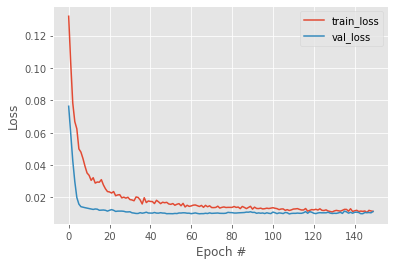

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), Numeric_Model.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), Numeric_Model.history["val_loss"], label="val_loss")
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.legend()

**COMPROBAMOS LOS RESULTADOS DEL MODELO**

In [ ]:
# Métricas Modelo numérica 1D
y_test_denorm = y_test * (y_reg.max() - y_reg.min()) + y_reg.min()
y_pred_numeric = num_model_final.predict(X_test)
y_pred_numeric_denorm = y_pred_numeric[:, 0] *  y_reg.max()
diferencia_numeric = y_pred_numeric_denorm.flatten()- y_test_denorm
porcentaje_diferencia_numeric = (diferencia_numeric / y_test_denorm) * 100
abs_porcentaje_diferencia_numeric = np.abs(porcentaje_diferencia_numeric)

error_denorm_numeric = np.abs(y_pred_numeric_denorm - y_test_denorm)
mean_numeric = np.mean(abs_porcentaje_diferencia_numeric)


print('Porcentaje medio de diferencia del GT: {0:.2f} % - Desviación típica: {0:.2f}'.format(mean_numeric ))
print('Error medio: {0:.2f}€'.format(error_denorm_numeric.mean()))

10/10 [==============================] - 0s 2ms/step
Porcentaje medio de diferencia del GT: 25.32 % - Desviación típica: 25.32
Error medio: 17.89€


**RESUMEN**

Vemos que usando los hiperparámetros dados por el optimizador obtenemos muy buenos resultados con un error de medio 17,89€ y una diferencia del 25% del GT. Para solo 1500 entradas pienso que el resultado es más que decente.

**CREAMOS EL MODELO PARA LAS IMÁGENES 1D**




In [ ]:
from keras.utils.np_utils import to_categorical
df_img, test_img = train_test_split(images, test_size=0.2,  random_state=42)
train_img, validation_img = train_test_split(df_img, test_size=0.2, random_state=42)


print(f'Dimensiones del dataset de training: {train_img.shape}')
print(f'Dimensiones del dataset de df_validation: {validation_img.shape}')
print(f'Dimensiones del dataset de test: {test_img.shape}')


Dimensiones del dataset de training: (960, 224, 224, 3)
Dimensiones del dataset de df_validation: (240, 224, 224, 3)
Dimensiones del dataset de test: (300, 224, 224, 3)


In [ ]:
#Redimensiono las imagenes para poder usar la red preentrenada y normalizamos

input_shape = (48, 48, 3)


# resize train set
X_train_resized = []
for img in train_img:
  X_train_resized.append(np.resize(img, input_shape) / 255)

X_train_resized = np.array(X_train_resized)
print(X_train_resized.shape)

# resize validation set
X_validation_resized = []
for img in validation_img:
  X_validation_resized.append(np.resize(img, input_shape) / 255)

X_validation_resized = np.array(X_validation_resized)
print(X_validation_resized.shape)


# resize test set
X_test_resized = []
for img in test_img:
  X_test_resized.append(np.resize(img, input_shape) / 255)

X_test_resized = np.array(X_test_resized)
print(X_test_resized.shape)

(960, 48, 48, 3)
(240, 48, 48, 3)
(300, 48, 48, 3)


**Buscamos los mejores parámetros para las imagenes**

In [ ]:
from keras.layers import Activation


def objetive_img(params_img):
  input_shape = (48, 48, 3)
  # Inizializamos el modelo
  img_model = Sequential()

  # Definimos una capa convolucional
  img_model.add(Conv2D(params_img['units'], kernel_size=(3, 3), activation='relu', input_shape=(input_shape)))
  img_model.add(MaxPooling2D(pool_size=(2, 2)))
  img_model.add(Dropout(0.3))

  # Definimos una segunda capa convolucional
  img_model.add(Conv2D(params_img['units'], kernel_size=(3, 3), activation='relu'))
  img_model.add(MaxPooling2D(pool_size=(2, 2)))
  img_model.add(Dropout(0.3))


  # Definimos una tercera capa convolucional
  img_model.add(Conv2D(params_img['units'], kernel_size=(3, 3), activation='relu'))
  img_model.add(MaxPooling2D(pool_size=(2, 2)))
  img_model.add(Dropout(0.3))

  # Definimos una cuarta capa convolucional
  img_model.add(Conv2D(params_img['units'], kernel_size=(3, 3), activation='relu'))
  img_model.add(MaxPooling2D(pool_size=(2, 2)))
  img_model.add(Dropout(0.3))

  # Añadimos nuestra regresión
  img_model.add(Flatten())
  img_model.add(Dense(1024, activation='relu'))
  img_model.add(Dropout(0.3))
  img_model.add(Dense(1, activation='sigmoid'))

  # Compilamos el modelo
  img_model.compile(loss='mean_squared_error',
                optimizer=Adam(lr=params_img['learning_rate'], decay = 1e-6), metrics=['mean_absolute_error'])

  history_img = img_model.fit(X_train_resized, y_train,
          batch_size=params_img['batch_size'],
          shuffle = True,
          epochs=params_img['epochs'],
          validation_data=(X_validation_resized,y_validation))

  best_val_loss = np.min(history_img.history['val_loss'])
  return {'loss': best_val_loss, 'status': STATUS_OK}




space_img = {
    'units': hp.choice('units', [32, 64, 128]),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [32,64,128]),
    'learning_rate': hp.choice('lr', [0.01, 0.001, 0.0001])

}

# Configurar el algoritmo de optimización
trials = Trials()
best = fmin(fn=objetive_img,
            space=space_img,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

# Obtener los mejores hiperparámetros y la pérdida mínima
best_params_img = hyperopt.space_eval(space_img, best)
min_loss_img = trials.best_trial['result']['loss']


# Imprimir los resultados
print('Mejores hiperparámetros:', best_params_img)
print('Pérdida mínima:', min_loss_img)

Epoch 1/100

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



Se han truncado las últimas 5000 líneas del flujo de salida.
30/30 [==============================] - 0s 9ms/step - loss: 0.1199 - mean_absolute_error: 0.2947 - val_loss: 0.1004 - val_mean_absolute_error: 0.2773

Epoch 17/150

30/30 [==============================] - 0s 9ms/step - loss: 0.1199 - mean_absolute_error: 0.2947 - val_loss: 0.1004 - val_mean_absolute_error: 0.2773

Epoch 18/150

30/30 [==============================] - 0s 9ms/step - loss: 0.1199 - mean_absolute_error: 0.2947 - val_loss: 0.1004 - val_mean_absolute_error: 0.2773

Epoch 19/150

30/30 [==============================] - 0s 10ms/step - loss: 0.1199 - mean_absolute_error: 0.2947 - val_loss: 0.1004 - val_mean_absolute_error: 0.2773

Epoch 20/150

30/30 [==============================] - 0s 9ms/step - loss: 0.1199 - mean_absolute_error: 0.2947 - val_loss: 0.1004 - val_mean_absolute_error: 0.2773

Epoch 21/150

30/30 [==============================] - 0s 10ms/step - loss: 0.1199 - mean_absolute_error: 0.2947 - val_los

**CREAMOS MODELO Y ENTRENAMOS EL MODELO CONVUNSIONAL CON LOS MEJORES HIPERPARÁMETROS**


In [ ]:

from keras.layers import Activation
n_epochs_img = 150
input_shape = (48, 48, 3)

# Inizializamos el modelo
img_model = Sequential()

# Definimos una capa convolucional
img_model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(input_shape)))
img_model.add(MaxPooling2D(pool_size=(2, 2)))
img_model.add(Dropout(0.5))

# Definimos una segunda capa convolucional
img_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
img_model.add(MaxPooling2D(pool_size=(2, 2)))
img_model.add(Dropout(0.5))


# Definimos una tercera capa convolucional
img_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
img_model.add(MaxPooling2D(pool_size=(2, 2)))
img_model.add(Dropout(0.5))

# Definimos una cuarta capa convolucional
img_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
img_model.add(Dropout(0.5))

# Añadimos nuestra regresión
img_model.add(Flatten())
img_model.add(Dense(512, activation='relu'))
img_model.add(Dropout(0.5))
img_model.add(Dense(1, activation='sigmoid'))

# Compilamos el modelo
img_model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001, decay = 1e-6), metrics=['mean_absolute_error'])





In [ ]:
img_model_grafica = img_model.fit(X_train_resized, y_train,
          batch_size=64,
          shuffle = True,
          epochs=n_epochs_img,
          validation_data=(X_validation_resized,y_validation))

Epoch 1/150
15/15 [==============================] - 1s 29ms/step - loss: 0.0432 - mean_absolute_error: 0.1629 - val_loss: 0.0526 - val_mean_absolute_error: 0.2044
Epoch 2/150
15/15 [==============================] - 0s 12ms/step - loss: 0.0364 - mean_absolute_error: 0.1495 - val_loss: 0.0499 - val_mean_absolute_error: 0.1984
Epoch 3/150
15/15 [==============================] - 0s 12ms/step - loss: 0.0357 - mean_absolute_error: 0.1494 - val_loss: 0.0364 - val_mean_absolute_error: 0.1651
Epoch 4/150
15/15 [==============================] - 0s 12ms/step - loss: 0.0343 - mean_absolute_error: 0.1441 - val_loss: 0.0343 - val_mean_absolute_error: 0.1593
Epoch 5/150
15/15 [==============================] - 0s 12ms/step - loss: 0.0338 - mean_absolute_error: 0.1419 - val_loss: 0.0351 - val_mean_absolute_error: 0.1618
Epoch 6/150
15/15 [==============================] - 0s 12ms/step - loss: 0.0330 - mean_absolute_error: 0.1406 - val_loss: 0.0333 - val_mean_absolute_error: 0.1570
Epoch 7/150
15/1

In [ ]:
test_loss_img = img_model.evaluate(X_test_resized, y_test)
print('Pérdida en el conjunto de prueba con los mejores hiperparámetros:', test_loss_img)

10/10 [==============================] - 0s 13ms/step - loss: 0.0361 - mean_absolute_error: 0.1439
Pérdida en el conjunto de prueba con los mejores hiperparámetros: [0.036140527576208115, 0.1439100205898285]


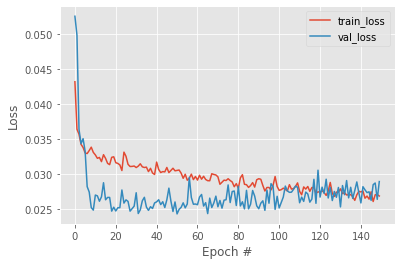

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs_img), img_model_grafica.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs_img), img_model_grafica.history["val_loss"], label="val_loss")
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.legend()

**MÉTRICAS MODELO CONVUNSIONAL**

In [ ]:
y_predict_img = img_model.predict(X_test_resized)
y_pred_img_denorm = y_predict_img[:, 0] *  y_reg.max()

diferencia_img = y_pred_img_denorm.flatten() - y_test_denorm
porcentaje_diferencia_img = (diferencia_img / y_test_denorm) * 100
abs_porcentaje_diferencia_img = np.abs(porcentaje_diferencia_img)

error_denorm_img = np.abs(y_pred_img_denorm - y_test_denorm)
mean_img = np.mean(abs_porcentaje_diferencia_img)
std_img = np.std(abs_porcentaje_diferencia_img)

print('Porcentaje medio de diferencia del GT: {0:.2f} % - Desviación típica: {0:.2f}'.format(mean_img ,std_img))
print('Error medio: {0:.2f}€'.format(error_denorm_img.mean()))

10/10 [==============================] - 0s 2ms/step
Porcentaje medio de diferencia del GT: 43.51 % - Desviación típica: 43.51
Error medio: 26.53€


El modelo se puede mejorar bastante, aunque habiendo probado diferentes hiperparámetros he visto que es bastante complicado para el modelo generalizar, al tener solo 1500 imágenes, y la complicación que tiene predecir el precio de apartamentos solo con fotos, los resultados no son óptimos. Hay apartamentos no muy estilosos en barrios de alta clase, y su precio sube bastante, así como otros apartamentos modernos y bien amueblados en barrios más humildes, sus precios bajan.
Usando los hiperparámetros dado por el optimizador ha mejorado el modelo en más de un 10 %.

In [ ]:
## Comentarios del profesor ###
La arquitectura convolucional está bien pero quizá la podrías mejorar con los siguientes consejos:
    - Utilizar un global MaxPooling en lugar de una capa flatten y quitar la densa después de la flatten
    - Aumentar el número de filtros conforme aumentamos el número de capas convolucionales
    -Disminuir un poco el dropout.
    -Uitlizar redes preentrenadas

**CREAMOS EL MODELO HÍBRIDO PERO ESTA VEZ CREAMOS LA RED CONVUNSIONAL DE UNA RED PREENTRENADA**

Compruebo primero que tanto me mejora el modelo preentrenado respecto al anterior.


In [ ]:
# creamos el modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
n_epochs_img_VGG = 130

for layer in base_model.layers:
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada.')


# cogemos la última capa del model y le añadimos nuestro (top_model)
last = base_model.layers[-1].output
img_model_2_output = Flatten()(last)
img_model_2_output = Dense(64, activation='relu')(img_model_2_output)
img_model_2_output = BatchNormalization()(img_model_2_output)
img_model_2_output = Dropout(0.5)(img_model_2_output)
img_model_2_output = Dense(32, activation='relu')(img_model_2_output)
img_model_2_output = BatchNormalization()(img_model_2_output)
img_model_2_output = Dropout(0.5)(img_model_2_output)

img_model_2_output = Dense(1, activation = 'sigmoid')(img_model_2_output)

#Modelo de imágenes del que usaremos en el híbrido
img_model_2 = Model(base_model.input, img_model_2_output)

Capa input_12 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_pool congelada.


In [ ]:
img_model_2.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001, decay = 1e-6), metrics=['mean_absolute_error'])




/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
img_model_2_grafic = img_model_2.fit(X_train_resized, y_train,
          batch_size=64,
          shuffle = True,
          epochs=n_epochs_img_VGG,
          validation_data=(X_validation_resized,y_validation))

Epoch 1/130
15/15 [==============================] - 2s 68ms/step - loss: 0.1301 - mean_absolute_error: 0.2948 - val_loss: 0.0474 - val_mean_absolute_error: 0.1921
Epoch 2/130
15/15 [==============================] - 0s 23ms/step - loss: 0.0944 - mean_absolute_error: 0.2478 - val_loss: 0.0339 - val_mean_absolute_error: 0.1580
Epoch 3/130
15/15 [==============================] - 0s 23ms/step - loss: 0.0793 - mean_absolute_error: 0.2214 - val_loss: 0.0314 - val_mean_absolute_error: 0.1509
Epoch 4/130
15/15 [==============================] - 0s 23ms/step - loss: 0.0643 - mean_absolute_error: 0.1952 - val_loss: 0.0318 - val_mean_absolute_error: 0.1518
Epoch 5/130
15/15 [==============================] - 0s 23ms/step - loss: 0.0617 - mean_absolute_error: 0.1915 - val_loss: 0.0308 - val_mean_absolute_error: 0.1483
Epoch 6/130
15/15 [==============================] - 0s 23ms/step - loss: 0.0558 - mean_absolute_error: 0.1848 - val_loss: 0.0284 - val_mean_absolute_error: 0.1396
Epoch 7/130
15/1

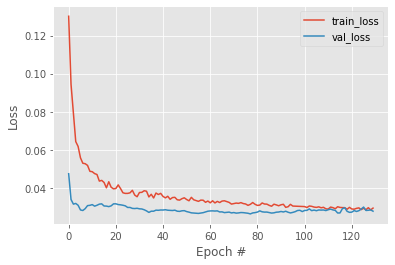

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs_img_VGG), img_model_2_grafic.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs_img_VGG), img_model_2_grafic.history["val_loss"], label="val_loss")
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.legend()

In [ ]:
y_predict_img_VGG = img_model_2.predict(X_test_resized)
y_pred_img_denorm_VGG = y_predict_img_VGG[:, 0] *  y_reg.max()

diferencia_img_VGG = y_pred_img_denorm_VGG.flatten() - y_test_denorm
porcentaje_diferencia_img_VGG = (diferencia_img_VGG / y_test_denorm) * 100
abs_porcentaje_diferencia_img_VGG = np.abs(porcentaje_diferencia_img_VGG)

error_denorm_img_VGG = np.abs(y_pred_img_denorm_VGG - y_test_denorm)
mean_img_VGG = np.mean(abs_porcentaje_diferencia_img_VGG)

print('Porcentaje medio de diferencia del GT: {0:.2f} % - Desviación típica: {0:.2f}'.format(mean_img_VGG ))
print('Error medio: {0:.2f}€'.format(error_denorm_img_VGG.mean()))

10/10 [==============================] - 1s 37ms/step
Porcentaje medio de diferencia del GT: 41.93 % - Desviación típica: 41.93
Error medio: 28.68€


Sin usar el optimizador debido al tiempo de espera requerido ya vemos una mejora de casi el 2% con unos parámetros al azar. Con el optimizador muy seguramente podríamos obtener un resultado mejor.
Optamos por elegir este modelo para la red híbrida

**CONCADENAMOS LAS SALIDAS DE LAS DOS RAMAS**

In [ ]:
from keras.layers.attention.multi_head_attention import activation
from keras.layers import concatenate
from keras.layers import InputLayer


ramas_fusionadas = concatenate([num_model_1.output, img_model_2.output ])

**CREAMOS LA RAMA DE SALIDA**

In [ ]:
modelo_hybrido_output = Dense(4, activation = 'relu')(ramas_fusionadas)
modelo_hybrido_output = Dense(1, activation = 'sigmoid')(modelo_hybrido_output)


**COMPILAMOS MODELO**

In [ ]:
modelo_hybrido_final = Model(inputs=[num_model_1.input, img_model_2.input ], outputs = modelo_hybrido_output)
modelo_hybrido_final.compile(optimizer= Adam(lr=0.001, decay = 1e-6), loss = 'mean_squared_error')

**ENTRENAMOS MODELO**

In [ ]:
H = modelo_hybrido_final.fit(x = [X_train, X_train_resized],y = y_train, validation_data = ([X_validation, X_validation_resized], y_validation), shuffle = True, epochs=120, batch_size= 128)

Epoch 1/120
8/8 [==============================] - 3s 100ms/step - loss: 0.1463 - val_loss: 0.1317
Epoch 2/120
8/8 [==============================] - 0s 44ms/step - loss: 0.1381 - val_loss: 0.1206
Epoch 3/120
8/8 [==============================] - 0s 42ms/step - loss: 0.1316 - val_loss: 0.1102
Epoch 4/120
8/8 [==============================] - 0s 41ms/step - loss: 0.1225 - val_loss: 0.1006
Epoch 5/120
8/8 [==============================] - 0s 40ms/step - loss: 0.1162 - val_loss: 0.0941
Epoch 6/120
8/8 [==============================] - 0s 40ms/step - loss: 0.1075 - val_loss: 0.0886
Epoch 7/120
8/8 [==============================] - 0s 41ms/step - loss: 0.1030 - val_loss: 0.0836
Epoch 8/120
8/8 [==============================] - 0s 40ms/step - loss: 0.0965 - val_loss: 0.0789
Epoch 9/120
8/8 [==============================] - 0s 40ms/step - loss: 0.0923 - val_loss: 0.0740
Epoch 10/120
8/8 [==============================] - 0s 42ms/step - loss: 0.0861 - val_loss: 0.0700
Epoch 11/120
8/8 [

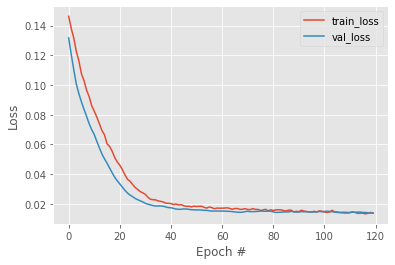

In [ ]:

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 120), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 120), H.history["val_loss"], label="val_loss")
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.legend()

In [ ]:
y_pred = modelo_hybrido_final.predict([X_test, X_test_resized])


10/10 [==============================] - 0s 15ms/step


In [ ]:
y_pred = modelo_hybrido_final.predict([X_test, X_test_resized])
y_pred_denorm_hybrid =  y_pred[:, 0] *  y_reg.max()

diferencia = y_pred_denorm_hybrid.flatten()- y_test_denorm
porcentaje_diferencia = (diferencia / y_test_denorm) * 100
abs_porcentaje_diferencia = np.abs(porcentaje_diferencia)

error_denorm = np.abs(y_pred_denorm_hybrid - y_test_denorm)
mean = np.mean(abs_porcentaje_diferencia)
std = np.std(abs_porcentaje_diferencia)

print('Porcentaje medio de diferencia del GT: {0:.2f} % - Desviación típica: {0:.2f}'.format(mean ,std))
print('Error medio: {0:.2f}€'.format(error_denorm.mean()))

10/10 [==============================] - 0s 12ms/step
Porcentaje medio de diferencia del GT: 27.51 % - Desviación típica: 27.51
Error medio: 19.08€


Obtenemos un resultado peor que el modelo numérico, pero mejor que los modelos 2D.
Seguramente podríamos optimizar los parámetros del modelo de imágenes, y posteriormente del híbrido obteniendo resultados mucho más óptimos.

 Vemos que con solo 1500 datos, las variables numéricas son más precisas, pues influyen notablemente sobre el precio de los apartamentos variables como la ubicación del mismo, el número de baños y habitaciones etc.

Personalmente, viendo los diferentes modelos y resultados, creo que la capacidad que tienen de precisión es muy alta, visto el poco número de datos usados para su entrenamiento.

**Gráfica de dispersión entre el GT y las predicciones del modelo híbrido y el numérico**

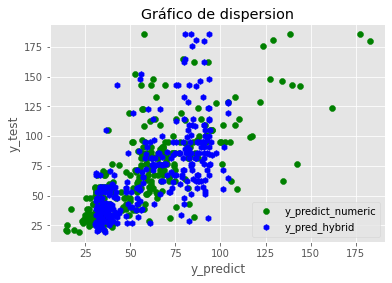

In [ ]:
#Gráfica de dispersión entre y_test y el modelo híbrido y numérico

plt.scatter(y_pred_numeric_denorm, y_test_denorm, color='green', marker = 'o', label='y_predict_numeric')
plt.scatter(y_pred_denorm_hybrid, y_test_denorm, color='blue', marker = 'h', label='y_pred_hybrid')


plt.xlabel('y_predict')
plt.ylabel('y_test')
plt.title('Gráfico de dispersion')
plt.legend()
plt.show()


**Gráfica de dispersión entre el GT y las predicciones del modelo híbrido y el de imágenes**

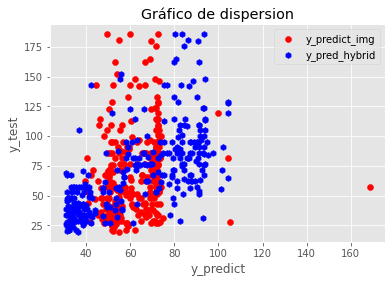

In [ ]:
plt.scatter(y_pred_img_denorm, y_test_denorm, color='red', marker = 'o', label='y_predict_img')
plt.scatter(y_pred_denorm_hybrid, y_test_denorm, color='blue', marker = 'h', label='y_pred_hybrid')
plt.xlabel('y_predict')
plt.ylabel('y_test')
plt.title('Gráfico de dispersion')
plt.legend()
plt.show()

En las gráficas de dispersión podemos ver como el peso del modelo numérico hace que la precisión en la predicción sea mejor.
En conclusión, entrenando con más datos el modelo de imágenes y mejorando los hiperparámetros vemos como podríamos hacer un modelo híbrido excelente con un error más bajo y mejor capacidad de generalización.

In [ ]:
#Observamos la estructura de nuestro modelo híbrido y la cantidad de parámetros entrenables.
modelo_hybrido_final.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 48, 48, 64)   1792        ['input_12[0][0]']               
                                                                                                  
 block1_conv2 (Conv2D)          (None, 48, 48, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 24, 24, 64)   0           ['block1_conv2[0][0]']           
                                                                                           

In [ ]:
## Comentarios del profesor ##
Quizá se podía haber mejorado la parte de imágenes si no pones tantas densas en el top model. De todas formas,
la práctica está genial, enhorabuena por el trabajo realizado.
